This notebook aims to compare a model built with HARK.ConsumptionSaving tools, and a model built with the GenericModel class.

In [1]:
from HARK.distribution import Lognormal
from HARK.simulation import GenericModel
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
from HARK.utilities import CRRAutility
import matplotlib.pyplot as plt
import numpy as np

Recall that the Perfect Foresight equations are as follows:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{C_t}~U(C_t) + \beta \aleph V_{t+1}(M_{t+1},P_{t+1}), \\
& s.t. & \\
%A_t &=& M_t - C_t, \\
M_{t+1} &=& R (M_{t}-C_{t}) + Y_{t+1}, \\
P_{t+1} &=& \Gamma_{t+1} P_t, \\
\end{eqnarray*}

With the following parameters:


| Param | Description | Code | Value |
| :---: | ---  | --- | :---: |
| $\rho$ | Relative risk aversion | $\texttt{CRRA}$ | 2.5 |
| $\beta$ | Discount factor | $\texttt{DiscFac}$ | 0.96 |
| $R$ | Risk free interest factor | $\texttt{Rfree}$ | 1.03 |
| $\newcommand{\LivFac}{\aleph}\LivFac$ | Survival probability | $\texttt{LivPrb}$ | 0.98 |
| $\Gamma$ | Income growth factor | $\texttt{PermGroFac}$ | 1.01 |


First, let's build and solve the normal perfect foresight model.

In [2]:
# This cell defines a parameter dictionary. You can expand it if you want to see what that looks like.
PF_dictionary = {
    'CRRA' : 2.5,
    'DiscFac' : 0.96,
    'Rfree' : 1.03,
    'LivPrb' : [1.0],
    'PermGroFac' : [1.01],
    'T_cycle' : 1,
    'cycles' : 0,
    'AgentCount' : 10000
}

pf = PerfForesightConsumerType(**PF_dictionary)
pf.solve()

We can extract the solution for use in the generic model.

Note that the `HARK.ConsumptionSaving` version of the Perfect Foresight model solves the _normalized_ [version of the problem](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA/#x1-30003), where all values are divided by the permanent growth factor.

This reduces the complexity of the solution algorithm, because the consumer function has only one argument, rather than two.

To get the un-normalized solution, the normalized solution needs to be multiplied by $\Gamma$.

In [3]:
## Note: the solution argument matches the notation in
##       the model configuration, m_
def pf_solution_normalized(m_):
    return pf.solution[0].cFunc(m_).tolist()

## non-normalized version
def pf_solution(m_, p_):
    return pf.solution[0].cFunc(m_).tolist() * p_

In [4]:
pf_solution_normalized(50)

3.3657865844813433

The consumer who expects a constant doubling of their income is inclined to consume twice as much as a consumer who expects to have a fixed income for their entire life.

In [5]:
pf_solution(50,2)

6.7315731689626865

To a provide a utility function to the model, we will prepare the CRRA utility function with a known risk aversion parameter.

In [6]:
def utility_function(c):
    return CRRAutility(c, PF_dictionary['CRRA'])

We can write the original model configuration for the `GenericModel` class like so:

In [7]:
#####
# PerfectForesight
#####

pf_config = {
    'params' : {
        'PermGroFac' : 1.01,
        'Rfree' : 1.03
    },
    'states' : {
    },
    'controls' : {
        'c' : pf_solution # consumption.
        # The function is the decision rule.
    },
    'post_states' : {
        'm' : lambda m_, p_, c, Rfree : (Rfree) * (m_ - c) + p_, #market assets
        'p' : lambda p_, PermGroFac: p_ * PermGroFac # income
    },
    'initial_states' : {
        'p_' : 1,
        'm_' : 0
    },
    'utility' : {
        'U' : utility_function
    }
}

#'DiscFac' : 0.96    - these are not yet supported for GenericModel

# 'LivPrb' : [0.98]  - Mortality not yet built into the model

The normalized version of the model can be written as follows.

In [8]:
#####
# PerfectForesight -- normalized ... 
#####

pf_nrm_config = {
    'params' : {
        'PermGroFac' : 1.01,
        'Rfree' : 1.03
    },
    'states' : {
    },
    'controls' : {
        'c' : pf_solution_normalized
    },
    'post_states' : {
        'm' : lambda m_, c, Rfree, PermGroFac : (Rfree / PermGroFac ) * (m_ - c) + 1, #market assets
    },
    'initial_states' : {
        'm_' : 0
    },
    'utility' : {
        'U' : utility_function
    }
}

The GenericModel is used just like the other HARK AgentTypes with respect to how simulations are simulated and ran.

In [9]:
pf_g = GenericModel(pf_config)
pf_g.initializeSim()
pf_g.simulate()

History is available for the simulated values. All the model variables are tracked.

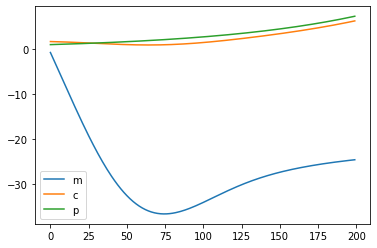

In [10]:
plt.plot(pf_g.agent.history['m'], label='m')
plt.plot(pf_g.agent.history['c'], label='c')
plt.plot(pf_g.agent.history['p'], label='p')
#plt.yscale('log')
plt.legend()

This is the plot of the normalized version.

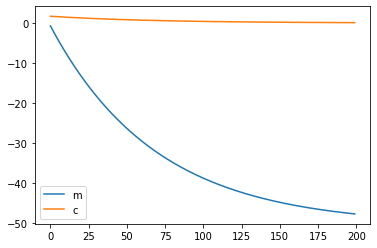

In [11]:
pf_nrm_g = GenericModel(pf_nrm_config)
pf_nrm_g.initializeSim()
pf_nrm_g.simulate()

plt.plot(pf_nrm_g.agent.history['m'], label='m')
plt.plot(pf_nrm_g.agent.history['c'], label='c')
#plt.yscale('log')
plt.legend()

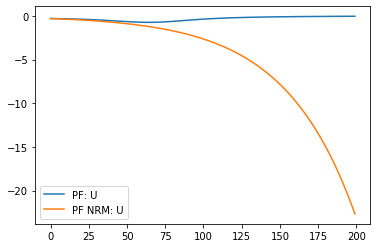

In [12]:
plt.plot(pf_g.agent.history['U'], label='PF: U')
plt.plot(pf_nrm_g.agent.history['U'], label='PF NRM: U')
plt.legend()

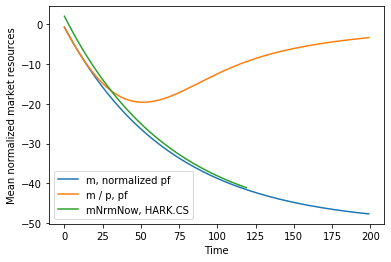

In [13]:
SimulationParams = {
    "AgentCount" : 100,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : 0.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 0.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.01,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

pf(**SimulationParams)

pf.track_vars = ['mNrmNow']
pf.initializeSim()
pf.simulate()


# Plot market resources over time
plt.plot(np.array(pf_nrm_g.agent.history['m']),
    label='m, normalized pf'
)

plt.plot(
    np.array(pf_g.agent.history['m']) / np.array(pf_g.agent.history['p']),
    label='m / p, pf'
)

plt.plot(pf.history['mNrmNow'][:,0], label="mNrmNow, HARK.CS")
plt.xlabel('Time')
plt.ylabel('Mean normalized market resources')
plt.legend()
plt.show()